In [1]:
import numpy as np
import pandas as pd
import numpy.ma as ma
import math
from mpl_toolkits.basemap import Basemap  # import Basemap matplotlib toolkit

import datetime
%matplotlib inline 
import matplotlib.pyplot as plt
from matplotlib import colors
from matplotlib.colors import LinearSegmentedColormap
import pygrib # import pygrib interface to grib_api

In [2]:
ais = pd.read_csv("ais-observations-20180320-20180321.csv")
print("Size of ais:", ais.size)
ais.describe()

Size of ais: 12512815


,mmsi,lon,lat,sog,cog,heading
count,1.787545e+06,1.787545e+06,1.787545e+06,1.787545e+06,1.787545e+06,1.787545e+06
mean,2.433939e+08,2.281273e+01,6.374050e+01,6.664055e+00,1.650444e+02,2.014721e+02
std,4.804646e+07,1.868030e+00,1.418599e+00,1.287539e+01,1.142009e+02,1.464549e+02
min,2.091850e+08,1.780826e+01,6.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.300813e+08,2.144750e+01,6.289179e+01,0.000000e+00,4.690000e+01,7.100000e+01
50%,2.303370e+08,2.287247e+01,6.398245e+01,2.500000e+00,1.796000e+02,1.960000e+02
75%,2.453060e+08,2.419174e+01,6.483310e+01,1.080000e+01,2.644000e+02,2.910000e+02
max,6.360923e+08,2.894537e+01,6.579819e+01,1.023000e+02,3.600000e+02,5.110000e+02


In [3]:
# Open the grib file
grbs = pygrib.open('icedata_2018-03-21T00-44-30_next_6hours.grb2')

In [13]:
def grb_to_list(grb_obj):
    ices = []
    for grid in grb_obj:
        timestamp = grid.validDate
        analysisTime = grid.analDate
        values = ma.masked_array(grid.values)
        lats, lons = grid.latlons()
        if lats.size != lons.size != values.size:
            return
        for x in range(0, len(values)):
            for y in range(0, len(values[x])):
                value = float(values[x][y]) * 100
                if math.isnan(value):
                    continue
                lat = lats[x][y]
                lon = lons[x][y]
                ices.append([timestamp, lat, lon, value, analysisTime])
    return ices

In [14]:
grbs.rewind()
grb = grbs.select(name='Sea-ice cover')
iceList = grb_to_list(grb)
concentrations = pd.DataFrame(iceList, columns=['timestamp', 'lat', 'lon', 'concentration', 'analysisTime'])
print(concentrations.head(10))
concentrations.describe()

/Users/villehak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:12: UserWarning: Warning: converting a masked element to nan.
  if sys.path[0] == '':


            timestamp        lat        lon  concentration        analysisTime
0 2018-03-20 19:00:00  56.992486  16.717000       0.000000 2018-03-20 18:00:00
1 2018-03-20 19:00:00  56.992486  16.750411       0.000000 2018-03-20 18:00:00
2 2018-03-20 19:00:00  56.992486  16.783821       0.000000 2018-03-20 18:00:00
3 2018-03-20 19:00:00  56.992486  16.884053       0.000000 2018-03-20 18:00:00
4 2018-03-20 19:00:00  56.992486  16.917464       0.000000 2018-03-20 18:00:00
5 2018-03-20 19:00:00  56.992486  16.950874       0.999999 2018-03-20 18:00:00
6 2018-03-20 19:00:00  56.992486  16.984285       0.999999 2018-03-20 18:00:00
7 2018-03-20 19:00:00  56.992486  17.017696       0.000000 2018-03-20 18:00:00
8 2018-03-20 19:00:00  56.992486  17.051106       0.000000 2018-03-20 18:00:00
9 2018-03-20 19:00:00  56.992486  17.084517       0.000000 2018-03-20 18:00:00


,lat,lon,concentration
count,3.996616e+06,3.996616e+06,3.996616e+06
mean,6.063071e+01,2.132005e+01,4.935330e+01
std,2.404133e+00,2.698677e+00,4.112871e+01
min,5.699249e+01,1.671700e+01,0.000000e+00
25%,5.864569e+01,1.932303e+01,0.000000e+00
50%,6.009850e+01,2.092674e+01,5.040001e+01
75%,6.235287e+01,2.293138e+01,9.400001e+01
max,6.589305e+01,3.021489e+01,1.000000e+02


In [10]:
def filterByLocation(points, latField, lonField, lat, lon, km):
    # 0.01 is a rough estimate of one kilometer in lat in norhern latitudes
    # 0.02 is a rough estimate of one kilometer in lon in norhern longitudes
    points = points.loc[(points[latField] > (lat - km * 0.01)) & (points[latField] < (lat + km * 0.01)) 
                  & (points[lonField] > (lon - km * 0.02)) & (points[lonField] < (lon + km * 0.02))]
    return points

def filterByTime(points, timeField, time, dateFormat, hours):
    starttime = time - datetime.timedelta(hours=hours)
    endtime = time + datetime.timedelta(hours=hours)
    return points.loc[(points[timeField] > starttime) & (points[timeField] < endtime)]

def findNearestIcePoint(timestamp, lat, lon, points, hours):
    points = filterByLocation(points, 'lat', 'lon', lat, lon, 1)
    points = filterByTime(points, 'timestamp', timestamp, '%Y-%m-%d %H:%M:%S.%f', 20)
    return points

In [7]:
MOVE_SPEED_THRESHOLD = 5
STOP_SPEED_THRESHOLD = 0.5

PREVIOUS_OBSERVATIONS_TIME_FRAME = 5 # store N minutues of observations

def filter_previous_observations_by_timestamp(df):
    if len(df) > 0:
        return df[lambda x: x['timestamp'] >= (df['timestamp'] - pd.Timedelta(15, unit='m'))]
    else:
        return df


def is_sudden_stop(d, prev):
    sog_mean = prev['sog'].mean()
    return sog_mean >= MOVE_SPEED_THRESHOLD and \
           d['sog'] < STOP_SPEED_THRESHOLD and \
           len(prev) > 1 and (prev['sudden_stopping'] == False).all()


def append_sudden_stopping(ais):
    ais.assign(sudden_stopping = None)
    vessels = {}

    for i, d in ais.iterrows():
        mmsi = d['mmsi']
        if not mmsi in vessels.keys():
            vessels[mmsi] = {}
            vessels[mmsi]['previous_observations'] = pd.DataFrame(columns=ais.columns)

        prev = filter_previous_observations_by_timestamp(vessels[mmsi]['previous_observations'])
        vessels[mmsi]['previous_observations'] = prev

        ais.set_value(i, 'sudden_stopping', is_sudden_stop(d, prev))

        vessels[mmsi]['previous_observations'] = vessels[mmsi]['previous_observations'].append(ais.loc[i])

    return ais

In [8]:
ais['timestamp'] = pd.to_datetime(ais['timestamp'])

testDate = '2018-03-20 20:00:00.000'
d = datetime.datetime.strptime(testDate, '%Y-%m-%d %H:%M:%S.%f')
starttime = d - datetime.timedelta(hours=1)
ais = ais.loc[(ais['timestamp'] > starttime)]

subAis = ais.head(10000)
subAis = append_sudden_stopping(subAis)
subAis = subAis.loc[subAis['sudden_stopping'] == True]
subAis.head(10)

/Users/villehak/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:337: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[key] = _infer_fill_value(value)
/Users/villehak/anaconda3/lib/python3.6/site-packages/pandas/core/indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,timestamp,mmsi,lon,lat,sog,cog,heading,sudden_stopping
11490,2018-03-20 19:01:17.060,230940340,23.716325,64.226382,0.4,319.0,130,True
19956,2018-03-20 19:09:28.704,212385000,21.738440,63.839225,0.2,245.2,180,True


In [15]:
i = 0
subAis['ic'] = 'NaN';
#print(subAis.head(10))

for index, row in subAis.iterrows():
    nearest = findNearestIcePoint(row['timestamp'], row['lat'], row['lon'], concentrations, 1)
    #print(row['timestamp'], row['lat'], row['lon'])
    if nearest.size > 0:
        subAis['ic'][index] = nearest['concentration'].iloc[0]
subAis.head(10)

/Users/villehak/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  if __name__ == '__main__':


,timestamp,mmsi,lon,lat,sog,cog,heading,sudden_stopping,ic
11490,2018-03-20 19:01:17.060,230940340,23.716325,64.226382,0.4,319.0,130,True,91.5
19956,2018-03-20 19:09:28.704,212385000,21.738440,63.839225,0.2,245.2,180,True,97.5


In [47]:
subAis['ic'].size

44

In [27]:
concentrations.to_csv('ice_concentrations.csv', sep=',')

44
44


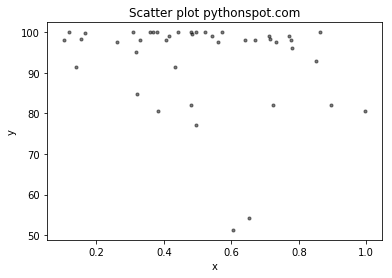

In [48]:
N = subAis['ic'].size
x = np.random.rand(N)
y = subAis['ic'].values
print(x.size)
print(y.size)
colors = (0,0,0)
area = np.pi*3
 
# Plot
plt.scatter(x, y, s=area, c=colors, alpha=0.5)
plt.title('Scatter plot pythonspot.com')
plt.xlabel('x')
plt.ylabel('y')
plt.show()